# D*-Algorithm

Hinweis: Beachten Sie bitte, dass bei der Verwendung von zufallsgenerierten Gridwelten oder Hindernissen die Möglichkeit besteht, dass kein gültiger Pfad existiert. In einem solchen Fall kann es zu einem Fehler im Notebook kommen.

Quellen:
- https://www.cs.cmu.edu/~motionplanning/lecture/AppH-astar-dstar_howie.pdf
- https://www.ri.cmu.edu/pub_files/pub3/stentz_anthony__tony__1994_2/stentz_anthony__tony__1994_2.pdf
- https://de.wikipedia.org/wiki/D*-Algorithmus#:~:text=Der%20D*%2DAlgorithmus%20wird,noch%20die%20Route%20berechnet%20wird.
- https://en.wikipedia.org/wiki/D*
- https://dibyendu-biswas.medium.com/d-d-lite-lpa-e7483779a7ca

In [1]:
from ipywidgets import Button, HBox, VBox, IntSlider, HTML, FloatText, Dropdown
import plotly.graph_objects as go
import numpy as np
import time
import copy
import networkx as nx
import heapq
from collections import deque
import random
import threading
from matplotlib import pyplot as plt

### Erstellung einer Gridwelt für die Anwendung der implementierten Algorithmen

In [2]:
def generate_gridworld(size, p_empty):
    gridworld = np.random.choice([' ', 'X'], size=(size, size), p=[p_empty, 1-p_empty])  #Zufälliges setzen von Hindernissen

    while True: #Zufälliges setzen von Start und Ziel
        start = np.random.randint(0, size, size=2)
        goal = np.random.randint(0, size, size=2)
        if not np.array_equal(start, goal) and gridworld[tuple(start)] != 'X' and gridworld[tuple(goal)] != 'X':
            gridworld[tuple(start)] = 'S'
            gridworld[tuple(goal)] = 'G'
            break

    return gridworld

def set_obstacle_to_gridworld(gridworld, obstacle):
    gridworld[tuple(obstacle)] = 'X'
    return gridworld

In [3]:
gridworld = generate_gridworld(12, 0.75)

#Erstellung einer fixen Gridwelt für Testzwecke
gridworld = np.array([['S', 'X', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
                      [' ', 'X', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
                      [' ', 'X', 'X', 'X', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
                      [' ', ' ', ' ', 'X', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
                      [' ', 'X', 'X', 'X', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
                      [' ', 'X', ' ', ' ', ' ', ' ', ' ', ' ', 'X', ' ', ' ', ' '],
                      [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'X', ' ', ' ', ' '],
                      [' ', ' ', ' ', ' ', ' ', ' ', 'X', ' ', 'X', ' ', ' ', 'G'],
                      [' ', ' ', ' ', ' ', ' ', ' ', 'X', ' ', ' ', ' ', ' ', ' '],
                      [' ', ' ', ' ', 'X', 'X', 'X', 'X', ' ', ' ', ' ', ' ', ' '],
                      [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
                      [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']])


In [4]:
colormapper = {
    ' ': 'white',  # empty space
    'S': 'green',  # start
    'G': 'red',    # goal
    'X': 'black',  # obstacle
    'B': 'yellow', # path found by algorithm
    'C': 'orange'  # closed history
}

colors = [colormapper[key] for key in colormapper.keys()]

def map_maze_to_numeric(maze, colormapper):
    numeric_maze = np.zeros_like(maze, dtype=float)
    for i, key in enumerate(colormapper.keys()):
        numeric_maze[np.array(maze) == key] = i
    return numeric_maze

### A*-Algorithmus

In [5]:
# Heuristik kann bei Bedarf angepasst werden.
def heuristic(actual_node, goal):
    # return abs(goal[0] - actual_node[0]) + abs(goal[1] - actual_node[1]) * 2
    return np.sqrt(abs(goal[0] - actual_node[0])**2 + abs(goal[1] - actual_node[1])**2)

# Implementierung von A* zur Veranschaulichung
def a_star(G, src, dest):
    open_set = [(0, src)]
    closed_lists = []
    closed_set = set()
    g_values = {src: 0}
    came_from = {}

    while open_set:
        _, current_node = heapq.heappop(open_set)

        if current_node == dest:
            path = []
            while current_node in came_from:
                path.append(current_node)
                current_node = came_from[current_node]
            path.append(src)
            path = path[::-1]
            closed_lists.append(list(closed_set))
            return path, closed_lists

        closed_set.add(current_node)
        closed_lists.append(list(closed_set))

        neighbors = list(G.neighbors(current_node))
        for neighbor in neighbors:
            if neighbor in closed_set:
                continue

            tentative_g = g_values[current_node] + G[current_node][neighbor]['weight']

            if neighbor not in [node[1] for node in open_set] or tentative_g < g_values[neighbor]:
                heapq.heappush(open_set, (tentative_g + heuristic(neighbor, dest), neighbor))
                came_from[neighbor] = current_node
                g_values[neighbor] = tentative_g

        open_set = sorted(open_set, key=lambda x: x[0])
    
    return [], closed_lists

### D*-Algorithmus

In [6]:
class NodeState:
    NEW = 0
    OPEN = 1
    CLOSED = 2
    RAISE = 3
    LOWER = 4

class Node:
    def __init__(self, point, state=NodeState.NEW, cost=float('inf'), next_point=None, neighbors=None):
        self.point = point
        self.state = state
        self.cost = cost
        self.next_point = next_point
        self.neighbors = neighbors if neighbors is not None else []

    def __lt__(self, other):
        return self.cost < other.cost


class DStar:
    def __init__(self, graph, start, goal):
        self.graph = graph
        self.nodes = {point: Node(point) for point in self.graph.nodes}
        for node in self.nodes.values():
            node.neighbors = [self.nodes[neighbor] for neighbor in graph.neighbors(node.point)]
        self.start = self.nodes[start]
        self.goal = self.nodes[goal]
        self.open_list = []
        self.raise_list = deque()
        self.lower_list = []
        self.closed_set = set()
        self.closed_history = []
        self.path = []

    def raise_wave(self, node):
        lower_neighbor_exists = any(neighbor.cost + 1 <= node.cost for neighbor in node.neighbors)

        if not lower_neighbor_exists:
            for neighbor in node.neighbors:
                if not neighbor.state == NodeState.RAISE:
                    neighbor.state = NodeState.RAISE
                    self.raise_list.append(neighbor)
            node.cost = float('inf')
            node.next_point = None
            node.state = NodeState.LOWER
            heapq.heappush(self.lower_list, node)
        else:
            node.state = NodeState.LOWER
            heapq.heappush(self.lower_list, node)

    def lower_wave(self, node):
        updated = False
        for neighbor in node.neighbors:
            if node.cost >= neighbor.cost + 1:
                node.cost = neighbor.cost + 1
                node.next_point = neighbor
                updated = True

        if not updated and node.cost == float('inf'):
            node.state = NodeState.LOWER
            node.next_point = None
            self.lower_list.append((node.cost, node))


    def expand(self, node):
        if node.state == NodeState.RAISE:
            self.raise_wave(node)
        elif node.state == NodeState.LOWER:
            self.lower_wave(node)
        else:
            for neighbor in node.neighbors:
                cost = node.cost + 1
                if cost < neighbor.cost:
                    neighbor.cost = cost
                    neighbor.next_point = node
                    heapq.heappush(self.open_list, (neighbor.cost, neighbor))

    def run(self):
        self.goal.cost = 0
        heapq.heappush(self.open_list, (self.goal.cost, self.goal))

        while self.open_list:
            _, current_node = heapq.heappop(self.open_list)
            if current_node in self.closed_set:
                continue
            self.closed_set.add(current_node)
            self.closed_history.append([entry.point for entry in self.closed_set])
            if current_node == self.start:
                self.__set_path__()
                return
            self.expand(current_node)
        print("Ziel nicht erreichbar")
        
    def set_obstacle_and_rerun(self, point):
        #set obstacle in nodes (remove from neighbors)
        obstacle = self.nodes[point]
        for neighbor in obstacle.neighbors:
            neighbor.state = NodeState.RAISE
            self.raise_list.append(neighbor)
            if obstacle in neighbor.neighbors:
                neighbor.neighbors.remove(obstacle)           

        #set obstacle in graph
        self.graph.remove_node(obstacle.point)
        self.nodes.pop(obstacle.point)
        for node in self.nodes.values():
            if obstacle.point in node.neighbors:
                node.neighbors.remove(obstacle.point)

        #reset closed set and history for visualization
        self.closed_set = set()
        self.closed_history = []

        #run raise wave
        while self.raise_list:
            current_node = self.raise_list.popleft()
            self.closed_set.add(current_node)
            self.closed_history.append([entry.point for entry in self.closed_set])
            self.expand(current_node)

        #sort lower list
        lower_list_with_lowest_cost_from_neighbor = [(min(neighbor.cost for neighbor in node.neighbors), node) for node in self.lower_list]
        self.lower_list = deque(sorted(lower_list_with_lowest_cost_from_neighbor, key=lambda x: x[0]))

        #run lower wave
        while self.lower_list:
            _, current_node = self.lower_list.popleft()
            self.closed_set.add(current_node)
            self.expand(current_node)
            
        #set new path
        self.__set_path__()

    def __set_path__(self):
        self.path = []
        current_node = self.start
        while current_node != self.goal:
            self.path.append(current_node.point)
            if self.path.__contains__(current_node.next_point.point):
                print("Ziel nicht erreichbar")
                break
            current_node = current_node.next_point
        self.path.append(self.goal.point)

    def __deep_copy__(self):
        return copy.deepcopy(self)


### Generierung von Maze-Sequenzen
Dies ist notwendig um den Ablauf der Algorithmen zu visualisieren.

In [7]:
def generate_gridworld_sequence(original_maze, optimal_path, visited_nodes, start, goal):
    maze_sequence = []

    for i in range(len(visited_nodes)):
        current_maze = copy.deepcopy(original_maze)

        for visited_node in visited_nodes[i]:
            current_maze[visited_node] = 'C'

        current_maze[start] = 'S'
        current_maze[goal] = 'G'

        maze_sequence.append([list(row) for row in current_maze])

    final_entry = copy.deepcopy(original_maze)
    for node in optimal_path:
        final_entry[node] = 'B'
    final_entry[start] = 'S'
    final_entry[goal] = 'G'
    maze_sequence.append([list(row) for row in final_entry])

    for i in range(len(maze_sequence)):
        maze_sequence[i] = map_maze_to_numeric(maze_sequence[i], colormapper)

    return maze_sequence

In [8]:
def convert_gridworld_to_graph(gridworld):
    G = nx.Graph()

    for i in range(gridworld.shape[0]):
        for j in range(gridworld.shape[1]):
            if gridworld[i, j] != 'X':
                G.add_node((i, j))
                if j > 0 and gridworld[i, j - 1] != 'X':
                    G.add_edge((i, j), (i, j - 1), weight=1)
                if j < gridworld.shape[1] - 1 and gridworld[i, j + 1] != 'X':
                    G.add_edge((i, j), (i, j + 1), weight=1)
                if i > 0 and gridworld[i - 1, j] != 'X':
                    G.add_edge((i, j), (i - 1, j), weight=1)
                if i < gridworld.shape[0] - 1 and gridworld[i + 1, j] != 'X':
                    G.add_edge((i, j), (i + 1, j), weight=1)

    return G

def get_start(gridworld):
    start = gridworld == 'S'
    start = np.where(start)
    start = (start[0][0], start[1][0])
    return start

def get_goal(gridworld):
    goal = gridworld == 'G'
    goal = np.where(goal)
    goal = (goal[0][0], goal[1][0])
    return goal

def get_random_obstacle(path):
    path = path[1:-1]
    return random.choice(path)

### Anwendung der Algorithmen

A*

In [9]:
G = convert_gridworld_to_graph(gridworld)

start = get_start(gridworld)
goal = get_goal(gridworld)

path, visited_nodes = a_star(G, start, goal)

a_gridworld_sequence = generate_gridworld_sequence(gridworld, path, visited_nodes, start, goal)

D*

In [10]:
start = get_start(gridworld)
goal = get_goal(gridworld)

dstar = DStar(G, start, goal)
dstar.run()

d_gridworld_sequence = generate_gridworld_sequence(gridworld, dstar.path, dstar.closed_history, start, goal)

In [11]:
cost_matrix1 = np.zeros_like(gridworld, dtype=float)
for node in dstar.nodes.values():
    cost_matrix1[node.point] = node.cost

D* mit Hinderniss

In [12]:
obstacle = get_random_obstacle(dstar.path)
obstacle = ((6,1)) #set fix for testing
gridworld = set_obstacle_to_gridworld(gridworld, obstacle)
dstar.set_obstacle_and_rerun(obstacle)

d_gridworld_obstacle_sequence = generate_gridworld_sequence(gridworld, dstar.path, dstar.closed_history, start, goal)

In [13]:
cost_matrix = np.zeros_like(gridworld, dtype=float)
for node in dstar.nodes.values():
    cost_matrix[node.point] = node.cost

### Visualisierung der Algorithmen

In [14]:
mazes_dict = {
    'a-stern': a_gridworld_sequence,
    'd-stern': d_gridworld_sequence,
    'd_star_updated': d_gridworld_obstacle_sequence
}

dropdown_values = ['a-stern', 'd-stern', 'd_star_updated']
functions_dropdown = Dropdown(options=dropdown_values, value=dropdown_values[0])
functions_dropdown.layout.margin = '0 0 0 10px'
dropdown_description = HTML(value="<b>Auswahl Algorithmus: </b>")
dropdown_description.layout.margin = '0 0 0 30px'

resetButton = Button(description='Reset', button_style='danger')
resetButton.layout.margin = '30px 0 0 10px'
resetButton_description = HTML(value="<b>Reset aller Parameter: </b>")
resetButton_description.layout.margin = '30px 0 0 30px'

index_slider = IntSlider(value=0, min=0, max=1, step=1, disabled=False, continuous_update=True, orientation='horizontal', readout=True)
index_slider.layout.margin = '10px 0 0 10px'
index_slider_description = HTML(value="<b>Iteration: </b>")
index_slider_description.layout.margin = '10px 0 0 30px'

wait_time_box = FloatText(value=.1, description='Wartezeit (s):', step=0.01, disabled=False)
wait_time_box.layout.margin = '10px 0 0 10px'

play_button = Button(description='Play', button_style='success')
play_button.layout.margin = '10px 0 0 10px'

stop_button = Button(description='Stop', button_style='danger')
stop_button.layout.margin = '10px 0 0 10px'

figureWidget = go.FigureWidget()

class PlayState:
    def __init__(self):
        self.is_playing = False

play_state = PlayState()

color_legend = [
    go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color=color), name=label)
    for label, color in colormapper.items()
]

figureWidget.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis=dict(dtick=1),
    yaxis=dict(scaleanchor="x", scaleratio=1, dtick=1, autorange="reversed"),
    legend=dict(x=1.02, y=1) 
)

def on_play_button_click(_):
    play_state.is_playing = True
    def run_animation():
        for i in range(index_slider.min, index_slider.max + 1):
            if not play_state.is_playing:
                break
            index_slider.value = i
            time.sleep(wait_time_box.value)
    threading.Thread(target=run_animation).start()

def on_stop_button_click(_):
    play_state.is_playing = False

def on_wait_time_change(change):
    wait_time = change['new']
    if wait_time < 0:
        wait_time_box.value = 0

def onClickResetButton(_):
    index_slider.value = 0


def index_changed(_):
    maze_sequence = mazes_dict[functions_dropdown.value]
    index_slider.max = len(maze_sequence) - 1

    if len(figureWidget.data) == 0:
        # Add the initial traces if they don't exist
        figureWidget.add_trace(go.Heatmap(z=maze_sequence[index_slider.value], showscale=False, hoverinfo='none', colorscale=colors, zmin=0, zmax=len(colormapper) - 1))
        figureWidget.add_traces(color_legend)
    else:
        # Update the existing Heatmap trace
        figureWidget.data[0].z = maze_sequence[index_slider.value]


index_slider.observe(index_changed, names='value')
resetButton.on_click(onClickResetButton)
wait_time_box.observe(on_wait_time_change, names='value')
play_button.on_click(on_play_button_click)
functions_dropdown.observe(index_changed, names='value')
functions_dropdown.observe(onClickResetButton, names='value')
stop_button.on_click(on_stop_button_click)

index_changed({'new': index_slider.value})

VBox([
    HTML("<h1 style='text-align:center'>Visualisierung der Gridworld</h1>"),
    HBox([dropdown_description, functions_dropdown]), 
    HBox([resetButton_description, resetButton]),
    HBox([index_slider_description, index_slider]),
    HBox([wait_time_box, play_button, stop_button]),
    figureWidget
])

Kosten vor und nach dem Hindernis

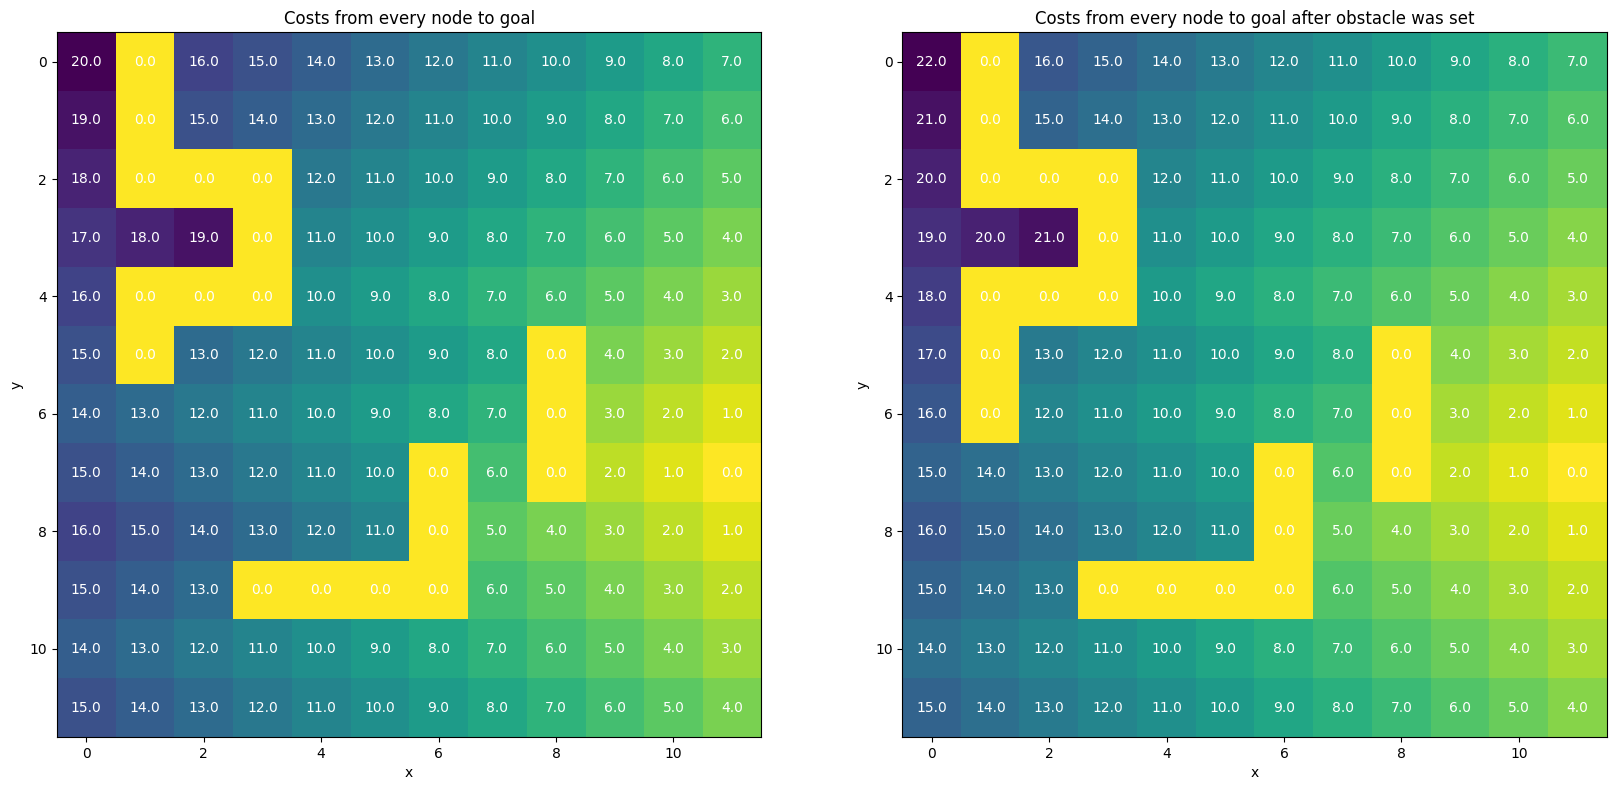

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cost_matrix1, cmap='viridis_r', interpolation='nearest')
ax1.set_title('Costs from every node to goal')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
for i in range(cost_matrix1.shape[0]):
    for j in range(cost_matrix1.shape[1]):
        ax1.text(j, i, cost_matrix1[i, j], ha="center", va="center", color="w")
ax2.imshow(cost_matrix, cmap='viridis_r', interpolation='nearest')
ax2.set_title('Costs from every node to goal after obstacle was set')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
for i in range(cost_matrix.shape[0]):
    for j in range(cost_matrix.shape[1]):
        ax2.text(j, i, cost_matrix[i, j], ha="center", va="center", color="w")
plt.show()